In [1]:
import scipy.io
import pickle 
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial

import torch
from Solver import *
# from NeuralNet import *
from timeit import default_timer


import sys
sys.path.append('../Utility')
import NeuralNet
import Numerics
import PlotDefault

# diffusivity is a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [2]:
L = 1.0
test_res = 100      # test data resolution
train_res = 100     # train data resolution

Nx = train_res
Ny = test_res
yy = np.linspace(0.0, L, Ny)
dy = yy[1] - yy[0]
f = -np.ones_like(yy)
dbc = np.array([0.0, 0.0]) 

GENERATE_TRAIN = False
GENERATE_TEST = False
# Training data  
if GENERATE_TRAIN:  
    xx, f, q, q_c, dq_c = generate_data(n_data=9)
    data_dict = {'xx': xx, 'f': f, 'q': q}
    with open(f'train-data-s{train_res}.pickle', 'wb') as f:
        pickle.dump(data_dict, f)
else:
    with open(f"train-s{train_res}.pickle",'rb') as f:
        data_dict = pickle.load(f)   
    xx, f, q = data_dict["xx"], data_dict["f"], data_dict["q"]

if GENERATE_TEST:
    # Test data
    def f_func1(xx_test):
        return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2
    def f_func2(xx_test):
        f = np.ones_like(xx_test)
        f[xx_test <= 0.5] = 0.0
        f[xx_test > 0.5] = 10.0
        return f
    def f_func3(xx_test):
        L = 1
        return 10*np.sin(2*np.pi*xx_test/L)

    f_funcs = [f_func1, f_func2, f_func3]
    xx_test, f_test, q_test, q_c_test, dq_c_test = np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny-1)), np.zeros((3, Ny-1))

    for i in range(3):
        f_func = f_funcs[i]
        xx_test[i,:], f_test[i,:], q_test[i,:], q_c_test[i,:], dq_c_test[i,:] = generate_data_helper(permeability_ref, f_func, 
                                                                                                     dt=1e-7, Nt=10_000_000, L=1.0, Nx =Ny)
    
    data_dict = {'xx_test': xx_test, 'f_test': f_test, 'q_test': q_test}
    with open(f'test-data-s{test_res}.pickle', 'wb') as f:
        pickle.dump(data_dict, f)
else:
    
    with open(f"test-data-s{test_res}.pickle",'rb') as f:
        data_dict = pickle.load(f)   
    xx_test, f_test, q_test = data_dict["xx_test"], data_dict["f_test"], data_dict["q_test"]

In [3]:
print(q.shape)
print(q_test.shape)

(60, 100)
(3, 100)


In [4]:
dq = np.copy(q)
ddq = np.copy(q)
for i in range(q.shape[0]):
    dq[i, :]  = Numerics.gradient_first(q[i,:], dy, bc = "one-sided")
    ddq[i, :] = Numerics.gradient_second(q[i,:], dy, bc = "one-sided")
 
dq_test = np.copy(q_test)
ddq_test = np.copy(q_test)
for i in range(q_test.shape[0]):
    dq_test[i, :]  = Numerics.gradient_first(q_test[i,:], dy, bc = "one-sided")
    ddq_test[i, :] = Numerics.gradient_second(q_test[i,:], dy, bc = "one-sided")
  
mu, flux, source = np.copy(q), np.copy(q), np.copy(q)
for i in range(q.shape[0]):
    mu[i,:], flux[i,:], source[i,:] = permeability_ref(np.vstack((q[i,:], dq[i,:])).T), flux_ref(np.vstack((q[i,:], dq[i,:])).T), source_ref_q(q[i,:], dy)
    
mu_test, flux_test, source_test = np.copy(q_test), np.copy(q_test), np.copy(q_test)
for i in range(q_test.shape[0]):
    mu_test[i,:], flux_test[i,:], source_test[i,:] = permeability_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), flux_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), source_ref_q(q_test[i,:], dy)


In [5]:
from tqdm.notebook import tqdm
layers = [8, 8, 8]
modes1 = [8, 8]
fc_dim = 8
activation = 'relu'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_list = ["diffusivity-fno.nn"] # ["diffusivity-fno.nn", "flux-fno.nn", "source-fno.nn"]

for nn_save_name in model_list:
    
    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity-fno.nn":
        # x_train = np.stack((q, dq), axis=-1)
        x_train = q[..., np.newaxis]
        y_train = mu[...,np.newaxis]
        in_dim = 1

    elif nn_save_name == "flux-fno.nn":
        # x_train = np.stack((q, dq), axis=-1)
        x_train = q[..., np.newaxis]
        y_train = flux[...,np.newaxis]
        in_dim = 1
    elif nn_save_name == "source-fno.nn":
        # x_train = np.stack((q, dq, ddq), axis=-1)
        x_train = q[..., np.newaxis]
        y_train = source[...,np.newaxis]
        in_dim = 3
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")


    x_train = torch.from_numpy(x_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 1000
    gamma = 0.5  
    epochs = 6001
    batch_size = 4

    net = NeuralNet.FNO1d(modes1=modes1, layers=layers,
                  fc_dim=fc_dim, in_dim=in_dim, out_dim=1, activation=activation).to(device)
    
    
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss()
    t0 = default_timer()
    pbar = tqdm(range(epochs), dynamic_ncols=True)
    for ep in pbar:
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            
            optimizer.zero_grad()
            out = net(x)
            # print(f'x shape: {x.shape}, y shape: {y.shape}, out shape: {out.shape}')
            # break
            loss = myloss(out , y) * 100
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()
        scheduler.step()
        avg_train_loss = train_l2 / len(train_loader)
        pbar.set_description(
            (
                f'Epoch: {ep}; Train MSE: {avg_train_loss}'
            )
        )
        if ep % 200 == 0:
            # train_l2/= ntrain
            # t2 = default_timer()
            # print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", avg_train_loss)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



start train nn :  diffusivity-fno.nn


  0%|          | 0/6001 [00:00<?, ?it/s]

In [ ]:
N_test_1d = 200
Lx_test_1d = 1.0
Ly_test_1d = 2.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(-Lx_test_1d, Lx_test_1d, N_test_1d)
x2_test_1d = np.linspace(-Ly_test_1d, Ly_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)
Z_test_2d = np.zeros(N_test)

for nn_save_name in ["diffusivity-fno.nn", "flux-fno.nn", "source-fno.nn"]:
    if nn_save_name  == "diffusivity-fno.nn":
        x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
        y_test = permeability_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
    elif nn_save_name  == "flux-fno.nn":
        x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
        y_test = flux_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
    elif nn_save_name  == "source-fno.nn":
        x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1), Z_test_2d)).T    
        y_test = source_ref(x_test).reshape((N_test, 1))
        trained_net = torch.load(nn_save_name)
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        

    print(x_test.shape)
    print(mu_scale, non_negative, filter_on, filter_sigma)
    y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_test_1d)  

    y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
    y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


    fig, ax = plt.subplots(ncols=3, sharey=True, nrows=1, figsize=((22,6)))

    for j in range(3):
        for i in range(q.shape[0]):
            ax[j].plot(q[i, :], dq[i, :],  "o", color = "black", fillstyle="none", alpha=0.1)
            ax[j].set_xlabel("q")
            if j == 0:
                ax[j].set_ylabel("dq")


    vmin, vmax = y_test_2d.min(), y_test_2d.max()
    im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_title("Reference")

    im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=ax[1])
    ax[1].set_title("Prediction")

    im2=ax[2].pcolormesh(X_test_2d, Y_test_2d, np.abs(y_test_2d - y_pred_2d), cmap = "Greys")
    fig.colorbar(im2, ax=ax[2])
    ax[2].set_title("Error")



    fig.subplots_adjust(bottom=0.15,top=0.92,left=0.08,right=0.97)



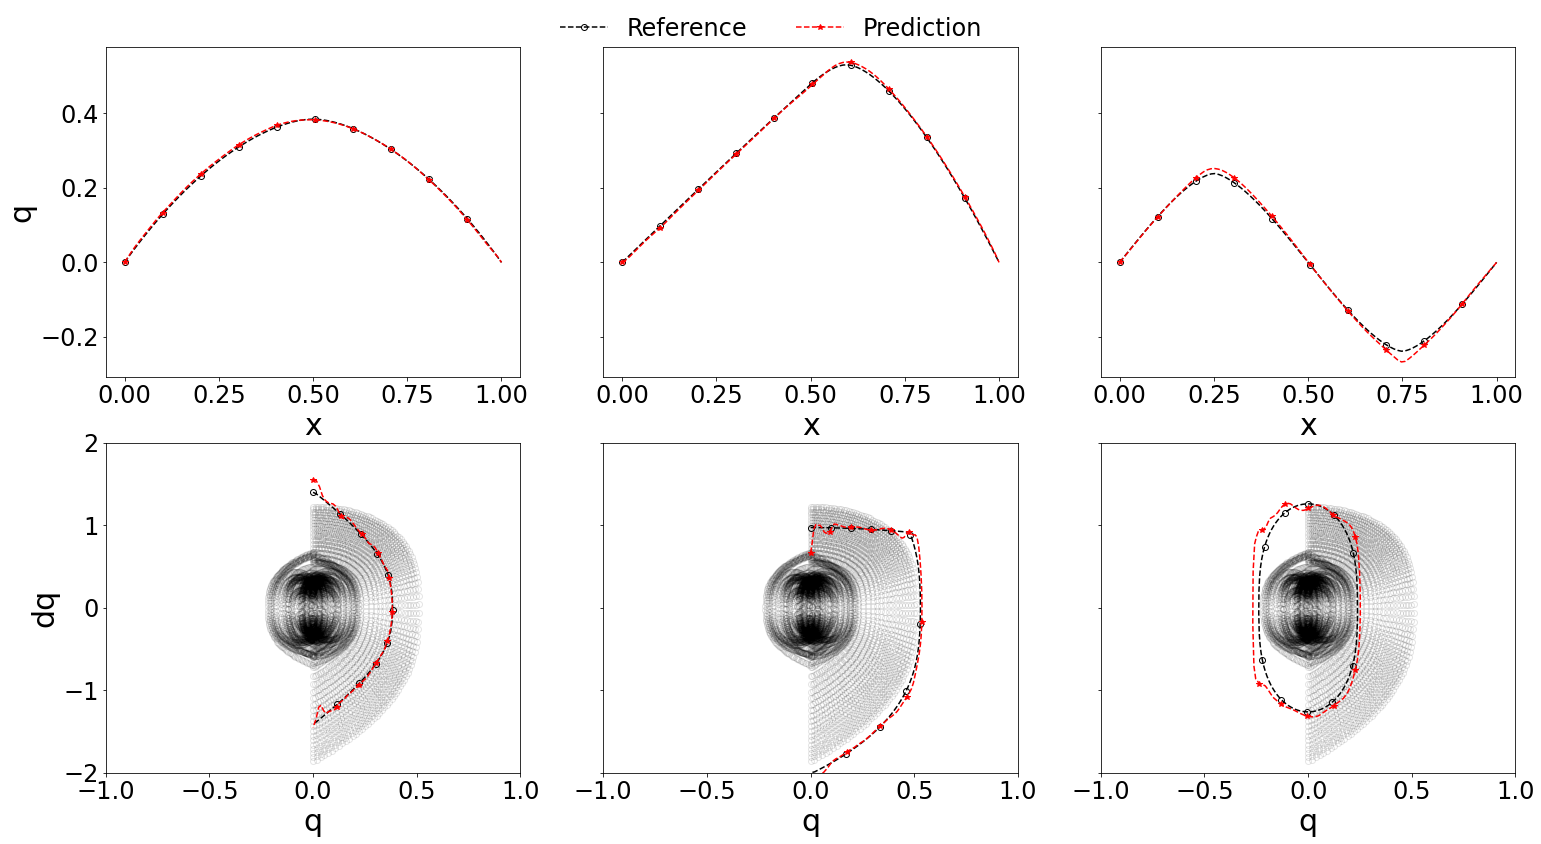

In [6]:
L, Nx =1.0, test_res
xx = np.linspace(0.0, L, Nx)
dx = xx[1] - xx[0]
dbc = np.array([0.0, 0.0])  
def f_func1(xx_test):
    return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2

def f_func2(xx_test):
    f = np.ones_like(xx_test)
    f[xx_test <= 0.5] = 0.0
    f[xx_test > 0.5] = 10.0
    return f

def f_func3(xx_test):
    L = 1
    return 10*np.sin(2*np.pi*xx_test/L)

f_funcs = [f_func1, f_func2, f_func3]



for nn_save_name in model_list:
    trained_net = torch.load(nn_save_name)

    fig, ax = plt.subplots(ncols=3, nrows=2, sharey="row", figsize=((22,12)))

    for i in range(3):

        f_func = f_funcs[i]
        f = f_func(xx)   
        filter_on = False
        if nn_save_name  == "diffusivity-fno.nn":
            nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=True, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
        elif nn_save_name  == "flux-fno.nn":
            nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
        elif nn_save_name  == "source-fno.nn":
            nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
            model = lambda q, yy, res : nummodel_source(nn_model, q, yy, res)
        else:
            print("nn_save_name : ", nn_save_name, " is not recognized")
            
            
            
        _, _, q_data = explicit_solve(model, f, dbc, dt = 1.0e-7, Nt = 10_000_000, save_every = 1_000_000, L = L)
        q_pred = q_data[-1, :]
        dq_pred  = Numerics.gradient_first(q_pred, dy, bc = "one-sided")


        ax[0,i].plot(xx_test[i,:], q_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[0,i].plot(xx_test[i,:], q_pred,  "--*", color="red", label="Prediction", markevery=10)
        if i == 0:
            ax[0,i].set_ylabel("q")
        ax[0,i].set_xlabel("x")

        for j in range(q.shape[0]):
            ax[1,i].plot(q[j, :], dq[j, :],  "o", color = "black", fillstyle="none", alpha=0.1)

        ax[1,i].plot(q_test[i,:], dq_test[i,:],  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
        ax[1,i].plot(q_pred, dq_pred,  "--*", color="red", label="Prediction", markevery=10)
        ax[1,i].set_xlim([-1,1])
        ax[1,i].set_ylim([-2,2])
        if i == 0:
            ax[1,i].set_ylabel("dq")
        ax[1,i].set_xlabel("q")

    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.08,top=0.92,left=0.08,right=0.97)
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)



In [10]:
q_pred.shape
xx_test.shape

(3, 100)

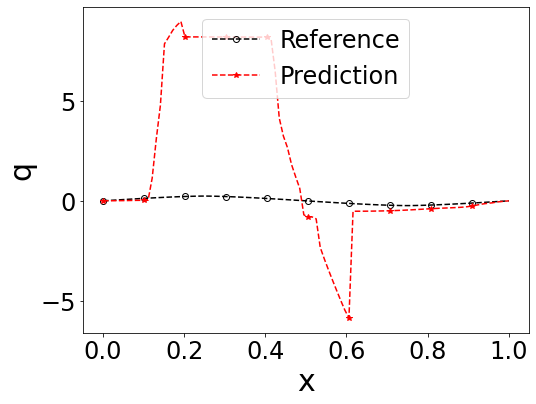

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(xx_test[2,:], q_test[2, :], "--o", color="black", fillstyle="none", label="Reference", markevery=10)
plt.plot(xx_test[2,:], q_pred, "--*", color="red", label="Prediction", markevery=10)
plt.legend(loc="upper center")
plt.xlabel('x')
plt.ylabel('q')
plt.show()